In [1]:
pip install gym tensorflow numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1')

def play_game(strategy, verbose=True):
    state = env.reset()
    print("Initial State Structure:", state)  # Print the initial state structure for debugging

    done = False
    while not done:
        if verbose:
            print(f"Current State: {state}")
        action = strategy(state)  # Define strategy function to choose action
        results = env.step(action)
        if verbose:
            print(f"Action Taken: {'Hit' if action == 1 else 'Stand'}, Results: {results}")
        
        state, reward, done, unexpected_bool, _ = results  # Corrected unpacking with an additional boolean

        if verbose:
            print(f"New State: {state}, Reward: {reward}, Game Over: {done}")
    if verbose:
        print(f"Game end. Reward: {reward}\n")
    return reward

def simple_strategy(state):
    """Simple example strategy: hit until reaching 17, then stand."""
    print(f"Debug: state received by strategy function: {state}")  # Debug print to see what is being passed
    actual_state = state[0]  # Extract the actual game state tuple from the first element
    score, dealer_score, usable_ace = actual_state  # Unpack the actual game state

    return 0 if score >= 17 else 1

# Test the game environment
play_game(simple_strategy)


Initial State Structure: ((10, 6, False), {})
Current State: ((10, 6, False), {})
Debug: state received by strategy function: ((10, 6, False), {})
Action Taken: Hit, Results: ((21, 6, True), 0.0, False, False, {})
New State: (21, 6, True), Reward: 0.0, Game Over: False
Current State: (21, 6, True)
Debug: state received by strategy function: (21, 6, True)


TypeError: cannot unpack non-iterable int object

In [3]:
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import random

# Environment setup
env = gym.make('Blackjack-v1')
state_size = 3  # Adjusted for the typical (sum, dealer's card, usable ace)
action_size = env.action_space.n

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()
    def update_epsilon(self):
        """Update the value of epsilon after each episode."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu'))  # Increased neurons
        model.add(Dense(64, activation='relu'))  # Added another hidden layer
        model.add(Dense(self.action_size, activation='linear'))
        learning_rate_schedule = ExponentialDecay(
            initial_learning_rate=1e-2,  # Starting learning rate
            decay_steps=10000,
            decay_rate=0.9,
            staircase=True)
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate_schedule))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize agent
agent = DQNAgent(state_size, action_size)


In [4]:
from collections import defaultdict


def train_agent(epochs=500, batch_size=32):
    rewards = []  # List to store the adjusted rewards for each episode
    epsilons = []  # List to store the epsilon values for each episode
    exploration_decay = 0.999
    min_exploration_rate = 0.1
    action_counts = defaultdict(int)
    reward_counts = defaultdict(int)

    for e in range(epochs):
        raw_state = env.reset()
        state = np.reshape(raw_state[0], [1, state_size])
        total_reward = 0

        while True:
            action = agent.act(state)
            action_counts[action] += 1
            next_state, reward, done, _, info = env.step(action)
            reward_counts[reward] += 1
            results = env.step(action)
            if len(results) == 4:
                raw_next_state, reward, done, info = results
            elif len(results) == 5:
                raw_next_state, reward, done, unexpected, info = results
            else:
                raise ValueError("Unexpected number of return values from env.step()")
            
            next_state = np.reshape(raw_next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                # Apply the adjusted reward only once at the end of the episode
                adjusted_reward = total_reward if total_reward > 0 else total_reward - 0.1
                rewards.append(adjusted_reward)
                agent.update_epsilon()  # Decaying epsilon
                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)  # Training the model
                print(f"Episode: {e+1}/{epochs}, Reward: {total_reward}, Epsilon: {agent.epsilon}")
                break
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
        # Decay the epsilon value, ensuring it does not go below the minimum threshold
        agent.epsilon = max(min_exploration_rate, agent.epsilon * exploration_decay)
    print("Action counts:", dict(action_counts))
    print("Reward counts:", dict(reward_counts))
    return rewards, epsilons



In [5]:

# Train the agent and collect data
rewards, epsilons = train_agent()


Episode: 1/500, Reward: -1.0, Epsilon: 0.995
Episode: 2/500, Reward: -1.0, Epsilon: 0.989034975
Episode: 3/500, Reward: -1.0, Epsilon: 0.983105710324875
Episode: 4/500, Reward: -1.0, Epsilon: 0.9772119915914774
Episode: 5/500, Reward: 1.0, Epsilon: 0.9713536057018864
Episode: 6/500, Reward: -1.0, Epsilon: 0.9655303408357037
Episode: 7/500, Reward: 1.0, Epsilon: 0.9597419864423936
Episode: 8/500, Reward: -1.0, Epsilon: 0.9539883332336714
Episode: 9/500, Reward: -1.0, Epsilon: 0.9482691731759355
Episode: 10/500, Reward: 1.0, Epsilon: 0.9425842994827458
Episode: 11/500, Reward: -1.0, Epsilon: 0.9369335066073466
Episode: 12/500, Reward: -1.0, Epsilon: 0.9313165902352355
1/1 [==============================] - 0s 53ms/step
Episode: 13/500, Reward: 1.0, Epsilon: 0.9257333472767753
Episode: 14/500, Reward: -1.0, Epsilon: 0.920183575859851
Episode: 15/500, Reward: -1.0, Epsilon: 0.9146670753225712
Episode: 16/500, Reward: -1.0, Epsilon: 0.9091836462060123
Episode: 17/500, Reward: -1.0, Epsilon:

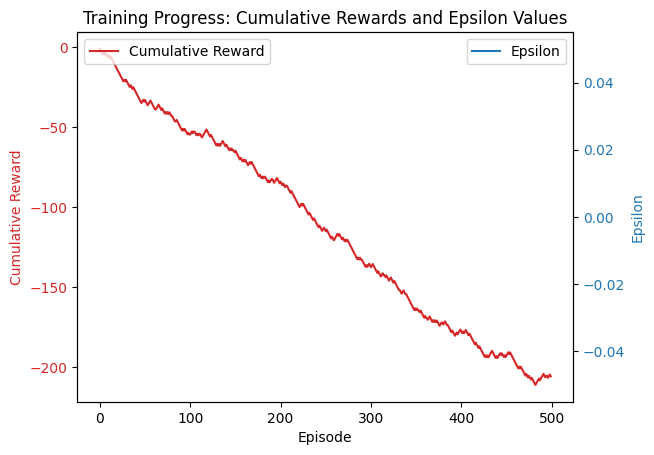

In [6]:
import matplotlib.pyplot as plt

def plot_training(rewards, epsilons):
    # Calculate cumulative rewards for better trend understanding
    cumulative_rewards = np.cumsum(rewards)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Cumulative Reward', color=color)
    ax1.plot(cumulative_rewards, color=color, label='Cumulative Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Epsilon', color=color)
    ax2.plot(epsilons, color=color, label='Epsilon')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Training Progress: Cumulative Rewards and Epsilon Values')
    plt.show()

# Assuming 'rewards' and 'epsilons' are lists of values collected during training
plot_training(rewards, epsilons)


In [7]:
import numpy as np

# Assuming 'rewards' is a list of rewards from each episode
mean_reward = np.mean(rewards)
variance_reward = np.var(rewards)

print(f"Mean Reward: {mean_reward:.2f}")
print(f"Variance of Reward: {variance_reward:.2f}")


Mean Reward: -0.41
Variance of Reward: 0.93
